#Cholesky Preconditioning in Solving Linear Systems

This notebook explores the application of **Cholesky preconditioning** in solving large linear systems efficiently and accurately.

Solving linear systems of the form

$
Ax = b,
$

where $A$ is a square matrix and $b$ is a vector, is a central problem in computational mathematics, physics, and engineering. When $A$ is **symmetric and positive definite**, methods such as **Cholesky decomposition** provide computationally efficient and numerically stable solutions.

However, as system size grows or when matrices become ill-conditioned, standard solution methods can become computationally expensive or suffer from numerical instability. In such cases, **Preconditioning** techniques aim to improve convergence rates of iterative solvers by transforming the system into a more favorable form.

## Aim of this Notebook

1. **Understand Cholesky Decomposition:**  
   Visualize how a symmetric positive definite matrix $A$ can be decomposed into $L L^\top$, where $L$ is lower triangular, and reconstruct $A$ from this factorization.

2. **Compare Direct Solution Methods:**  
   Contrast the classical **Gauss-Jordan elimination** and **Cholesky decomposition** in solving linear systems, focusing on computational efficiency and timing.

3. **Explore Preconditioning with the Conjugate Gradient Method:**  
   Compare the iterative conjugate gradient solver both with and without Cholesky preconditioning. Analyze the effect of preconditioning on convergence speed and accuracy.

## What You Will Learn
- The differences in speed and stability between Gauss-Jordan and Cholesky methods.
- The role of preconditioning in accelerating iterative solvers.
- How matrix properties and problem size affect solver performance.

By the end of this notebook, you will gain a grasp of Cholesky preconditioning and its advantages in solving large, symmetric positive definite linear systems efficiently.
Run each code cell sequentially.


# Visualizing Cholesky Decomposition

The **Cholesky decomposition** factorizes a symmetric, positive definite matrix $A$ into

$
A = LL^\top,
$

where $L$ is a lower triangular matrix with positive diagonal elements. This decomposition simplifies solving linear systems, inverting matrices, and computing determinants.

The advantages are:

- Efficient computation: roughly half the work compared to standard LU factorization.
- Numerical stability for positive definite matrices.

Run the cell. The console output will show the numeric values of:

- Original matrix $A$,
- Lower triangular matrix $L$,
- Transpose $L^\top$,
- Reconstructed matrix $L L^\top$.

Heatmaps visually display the numerical values for intuitive understanding of the matrix entries and the factorization pattern.

Original Matrix A:
 [[0.471997   0.63702974 0.56295746]
 [0.63702974 1.00393772 0.90622678]
 [0.56295746 0.90622678 0.84229519]]

Cholesky Factor L:
 [[0.68702038 0.         0.        ]
 [0.92723558 0.37969974 0.        ]
 [0.81941886 0.3856533  0.14872613]]

Transpose Lᵀ:
 [[0.68702038 0.92723558 0.81941886]
 [0.         0.37969974 0.3856533 ]
 [0.         0.         0.14872613]]

Reconstructed Matrix A from L * Lᵀ:
 [[0.471997   0.63702974 0.56295746]
 [0.63702974 1.00393772 0.90622678]
 [0.56295746 0.90622678 0.84229519]]


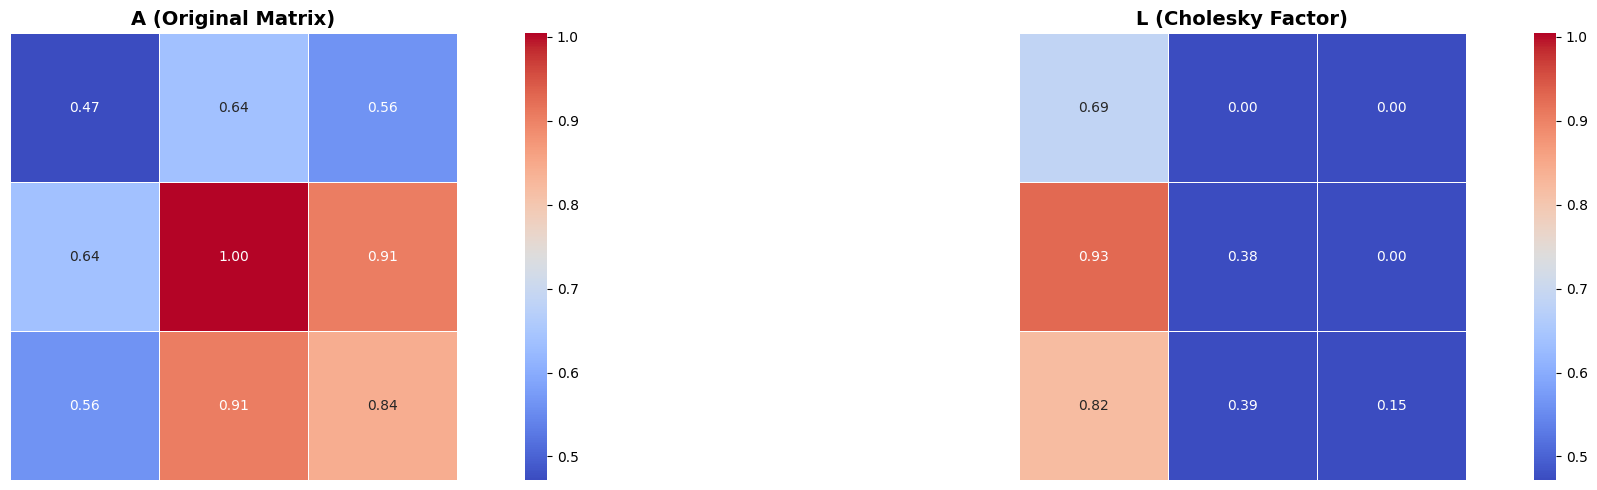

In [ ]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns

def plot_matrices_as_equation(A, L):

    fig, axes = plt.subplots(1, 2, figsize=(24, 5))

    matrices = [A, L]
    titles = ["A (Original Matrix)", "L (Cholesky Factor)"]

    vmin, vmax = A.min(), A.max()

    for ax, matrix, title in zip(axes, matrices, titles):
        if matrix is not None and title in ["A (Original Matrix)", "L (Cholesky Factor)"]:
            sns.heatmap(matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5,
                        square=True, cbar=True, ax=ax, vmin=vmin, vmax=vmax)
        ax.set_title(title, fontsize=14, fontweight="bold")
        ax.axis("off") if matrix is None else ax.set_xticks([]), ax.set_yticks([])

    plt.tight_layout()
    plt.show()

def cholesky_decomposition_visual():
    A = np.random.rand(3, 3)
    A = np.dot(A, A.T)  # Make it symmetric and positive definite

    L_numpy = la.cholesky(A, lower=True)
    A_reconstructed = L_numpy @ L_numpy.T

    print("Original Matrix A:\n", A)
    print("\nCholesky Factor L:\n", L_numpy)
    print("\nTranspose Lᵀ:\n", L_numpy.T)
    print("\nReconstructed Matrix A from L * Lᵀ:\n", A_reconstructed)

    plot_matrices_as_equation(A, L_numpy)

cholesky_decomposition_visual()


# Comparing Gauss-Jordan Elimination and Cholesky Decomposition

Solving linear systems \(Ax = b\) is a fundamental task across domains. This cell compares two direct solution methods:

- **Gauss-Jordan Elimination:** a general method applicable to any invertible matrix.
- **Cholesky Decomposition:** an efficient method for symmetric positive definite matrices.

These methods are compared on large matrices having **high condition numbers** (ill-conditioned matrices) to examine solver stability and speed.

## Key Concepts

- **Gauss-Jordan elimination** transforms the augmented matrix $[A | b]$ to reduced row echelon form, revealing the solution vector $x$.
- **Cholesky decomposition** factorizes $A = LL^\top$, then solves via forward and backward substitution.
- The **condition number** measures sensitivity of the system to numerical errors; higher values indicate greater ill-conditioning.

## How to Use

- Run the cell.
- Enter the desired matrix size (e.g., 5, 10, 50, or 100).
- Observe the printed matrix $A$ and vector $b$.
- Review the solutions computed by each method.
- Observe the timing results to understand relative efficiency.

## Expected Outcomes

- Cholesky decomposition generally outperforms Gauss-Jordan for symmetric positive definite matrices.
- Ill-conditioning can increase solution errors and computation times.
- This comparison reveals the practical importance of algorithm selection based on matrix properties.
- Timing differences become more significant as matrix size grows.


In [ ]:
import numpy as np
import scipy.linalg as la
import time
import matplotlib.pyplot as plt

def gauss_jordan(A, b):
    n = len(A)
    augmented_matrix = np.hstack([A, b.reshape(-1, 1)])

    for i in range(n):
        augmented_matrix[i] = augmented_matrix[i] / augmented_matrix[i, i]

        for j in range(n):
            if i != j:
                augmented_matrix[j] = augmented_matrix[j] - augmented_matrix[i] * augmented_matrix[j, i]

    return augmented_matrix[:, -1]

def cholesky_decomposition(A, b):
    L = np.linalg.cholesky(A)
    y = np.linalg.solve(L, b)
    x = np.linalg.solve(L.T, y)

    return x

def create_conditioned_matrix(n):
    A = np.random.rand(n, n)
    A = np.dot(A, A.T)
    condition_factor = 1e10
    A += np.eye(n) * condition_factor
    return A

def get_user_input():
    n = int(input("Enter the size of the matrix n (n x n): "))
    A = create_conditioned_matrix(n)
    b = np.random.rand(n, 1)
    return A, b, n

def display_matrix(A, name, max_size=10):
    print(f"\n{name}:")
    if A.shape[0] > max_size:
        print("(Showing top-left 3x3 elements for readability)")
        print(A[:3, :3])
    else:
        print(A)

def display_vector(v, name, max_size=10):
    print(f"\n{name}:")
    if v.shape[0] > max_size:
        print("(Showing first 5 elements)")
        print(v[:5].flatten())
    else:
        print(v.flatten())

def compare_methods():
    A, b, n = get_user_input()

    display_matrix(A, "Matrix A")
    display_vector(b, "Right-hand side vector b")

    print("\nUsing Gauss-Jordan to solve the system Ax = b:")
    start_time = time.time()
    x_gauss_jordan = gauss_jordan(A, b)
    gauss_jordan_time = time.time() - start_time
    display_vector(x_gauss_jordan, "Solution using Gauss-Jordan")
    print(f"\033[1mTime taken by Gauss-Jordan: {gauss_jordan_time:.6f} seconds\033[0m")

    print("\nUsing Cholesky Decomposition to solve the system Ax = b:")
    start_time = time.time()
    x_cholesky = cholesky_decomposition(A, b)
    cholesky_time = time.time() - start_time
    display_vector(x_cholesky, "Solution using Cholesky")
    print(f"\033[1mTime taken by Cholesky: {cholesky_time:.6f} seconds\033[0m")

    if cholesky_time < gauss_jordan_time:
        print(f"\n\033[1mCholesky Decomposition is faster than Gauss-Jordan by {gauss_jordan_time - cholesky_time:.6f} seconds.\033[0m")
    else:
        print(f"\033[1mGauss-Jordan method is slower than Cholesky by {cholesky_time - gauss_jordan_time:.6f} seconds.\033[0m")

compare_methods()

Enter the size of the matrix n (n x n): 12

Matrix A:
(Showing top-left 3x3 elements for readability)
[[1.00000000e+10 3.37927413e+00 2.99410057e+00]
 [3.37927413e+00 1.00000000e+10 3.44368114e+00]
 [2.99410057e+00 3.44368114e+00 1.00000000e+10]]

Right-hand side vector b:
(Showing first 5 elements)
[0.51438454 0.37999882 0.08464579 0.26866088 0.7744781 ]

Using Gauss-Jordan to solve the system Ax = b:

Solution using Gauss-Jordan:
(Showing first 5 elements)
[5.14384537e-11 3.79998823e-11 8.46457882e-12 2.68660875e-11
 7.74478094e-11]
Time taken by Gauss-Jordan: 0.001176 seconds

Using Cholesky Decomposition to solve the system Ax = b:

Solution using Cholesky:
(Showing first 5 elements)
[5.14384537e-11 3.79998823e-11 8.46457882e-12 2.68660875e-11
 7.74478094e-11]
Time taken by Cholesky: 0.000092 seconds

Cholesky Decomposition is faster than Gauss-Jordan by 0.001084 seconds.


# Conjugate Gradient Method with and without Cholesky Preconditioning

Iterative methods such as the **Conjugate Gradient (CG)** algorithm are widely used for solving large sparse linear systems, especially when $A$ is symmetric positive definite.

The convergence speed of CG depends heavily on the **spectral properties** (eigenvalues) of $A$. When $A$ is ill-conditioned or has clustered eigenvalues, convergence slows.

**Preconditioning** improves convergence by transforming the system into

$$
M^{-1} A x = M^{-1} b,
$$

where $M$ approximates $A$ but is easier to invert. Ideally, $M^{-1} A$ has a more favorable eigenvalue distribution.


## Cholesky Preconditioning

Here, the Cholesky factor $L$ of $A$ is used as the preconditioner:

$$
M = LL^\top.
$$

Applying $M^{-1}$ involves solving triangular systems efficiently.


### In the below example,

- Adjust the **Matrix Size** slider to set the matrix dimension.
- Adjust the **Tolerance** slider to control solver precision.
- Observe:
  - Heatmap of the generated matrix $A$,
  - Number of CG iterations needed with and without preconditioning,
  - Errors relative to the exact solution,
  - Tabular comparison of solutions.


- Preconditioning reduces the number of iterations, speeding convergence.

This cell demonstrates the power of Cholesky preconditioning in accelerating iterative solvers. The interactive interface invites experimentation with matrix size and tolerance, reinforcing understanding of practical numerical linear algebra.


In [ ]:
import numpy as np
import scipy.linalg as linalg
from scipy.sparse.linalg import cg, LinearOperator
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

def plot_matrix_heatmap(A, title="Matrix Heat Map"):
    plt.figure(figsize=(6, 5))
    heatmap = plt.imshow(A, cmap='viridis', aspect='auto')
    plt.colorbar(heatmap, label='Value')
    plt.title(title)
    plt.show()

matrix_size_widget = widgets.IntSlider(value=500, min=50, max=1500, step=50, description="Matrix Size:", continuous_update=False)
tolerance_widget = widgets.FloatSlider(value=1e-6, min=1e-12, max=1e-1, step=1e-5, description="Tolerance:", continuous_update=False)

def run_conjugate_gradient(size, tolerance):
    size = int(size)
    A_random = np.random.rand(size, size)
    A = np.dot(A_random, A_random.T)
    b = np.random.rand(size)
    plot_matrix_heatmap(A, title=f"Heat Map of {size}x{size} Matrix")


    def conjugate_gradient_no_precondition(A, b):
        residuals = []
        iterations = 0

        def callback(xk):
            nonlocal iterations
            iterations += 1
            residuals.append(np.linalg.norm(A @ xk - b))

        x, info = cg(A, b, rtol=tolerance, maxiter=5000, callback=callback)
        return x, iterations, residuals

    def conjugate_gradient_with_precondition(A, b):
        residuals = []
        iterations = 0

        L = np.linalg.cholesky(A)

        def preconditioner_op(x):
            y = np.linalg.solve(L, x)
            return np.linalg.solve(L.T, y)

        preconditioner = LinearOperator((A.shape[0], A.shape[0]), matvec=preconditioner_op)

        def callback(xk):
            nonlocal iterations
            iterations += 1
            residuals.append(np.linalg.norm(A @ xk - b))

        x, info = cg(A, b, M=preconditioner, rtol=tolerance, maxiter=5000, callback=callback)
        return x, iterations, residuals

    x_no_precondition, iterations_no_precondition, residuals_no_precondition = conjugate_gradient_no_precondition(A, b)
    x_with_precondition, iterations_with_precondition, residuals_with_precondition = conjugate_gradient_with_precondition(A, b)

    exact_solution = np.linalg.solve(A, b)

    error_no_precondition = np.linalg.norm(x_no_precondition - exact_solution)
    error_with_precondition = np.linalg.norm(x_with_precondition - exact_solution)

    print(f"\nMatrix Size: {size} x {size}")
    print(f"Tolerance: {tolerance}")
    print("\nConjugate Gradient Results:")
    print(f"  - Without Preconditioning: {iterations_no_precondition} iterations")
    print(f"  - With Preconditioning: {iterations_with_precondition} iterations")

    print("\nError in Solution:")
    print(f"  - Without Preconditioning: {error_no_precondition:.6e}")
    print(f"  - With Preconditioning: {error_with_precondition:.6e}")
    display(Markdown(f"""

### Solution Comparison (First 5 Elements)

| Index | Exact Solution | No Preconditioning | With Preconditioning |
|-------|---------------|--------------------|----------------------|
""" + "\n".join([f"| {i} | {exact_solution[i]:.6f} | {x_no_precondition[i]:.6f} | {x_with_precondition[i]:.6f} |" for i in range(5)]) + "\n"))



widgets.interactive(run_conjugate_gradient, size=matrix_size_widget, tolerance=tolerance_widget)


interactive(children=(IntSlider(value=500, continuous_update=False, description='Matrix Size:', max=1500, min=…